In [20]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.feature_selection import SelectKBest, f_regression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
from datetime import datetime

# pipeline
from sklearn.compose import make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

# nn
from scikeras.wrappers import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

#load and save
import joblib
import pickle
import os

In [2]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import TransformedTargetRegressor

class AttributeCombiner(BaseEstimator, TransformerMixin):

    def __init__(self, add_total_visual_content=True, add_paragraph_body_ratio=True):
        self.add_total_visual_content=add_total_visual_content
        self.add_paragraph_body_ratio=add_paragraph_body_ratio


    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X = X.values
        total_visual_content = X[:, no_of_images_index] + X[:, no_of_quotes_index]
        paragraph_body_ratio = X[:, mean_paragraph_len_index] / X[:, body_len_index]
        if self.add_total_visual_content and not self.add_paragraph_body_ratio:
            return np.c_[X, total_visual_content]
        elif self.add_paragraph_body_ratio and not self.add_total_visual_content:
            return np.c_[X, paragraph_body_ratio]
        elif self.add_paragraph_body_ratio and self.add_total_visual_content:
            return np.c_[X, total_visual_content, paragraph_body_ratio]
        else:
            return X


class ColumnStringConverter(BaseEstimator, TransformerMixin):
    def __init__(self, convert=True):
        self.convert=convert
      
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for idx, col in enumerate(X.columns, start=0):

            X[col] = X[col].astype(str)

        return X

In [3]:
df = pd.read_csv("train_data.csv")

In [4]:
df.head(2)

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,no_of_image,is_personalised,no_of_quotes,is_timer,no_of_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
0,1,3,76,10439,39,5,1,Noon,6,26,...,0,0,0,0,0,0,0,0,14,0.103079
1,2,3,54,2570,256,5,1,Morning,2,11,...,0,0,0,0,0,0,0,0,10,0.700000


In [5]:
df.shape

(1888, 22)

In [6]:
df["click_rate"] = df["click_rate"] + 0.000001

In [7]:
df[df['click_rate'] == 0.000001]

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,no_of_image,is_personalised,no_of_quotes,is_timer,no_of_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
56,57,3,85,9717,30,5,1,Noon,15,9,...,0,0,0,0,2,0,0,0,16,0.000001
68,69,3,98,21569,20,1,0,Evening,15,13,...,2,0,0,0,1,1,0,0,16,0.000001
231,232,3,54,1576,87,3,0,Evening,9,34,...,0,1,3,0,0,0,0,0,6,0.000001
251,252,3,78,14517,32,3,0,Evening,15,31,...,1,0,2,0,3,0,0,0,5,0.000001
437,438,3,67,4084,103,1,0,Evening,6,26,...,1,0,0,0,0,0,0,0,10,0.000001
438,439,3,67,4863,166,1,0,Evening,6,26,...,1,0,0,0,0,0,0,0,10,0.000001
593,594,3,54,23,4,5,1,Noon,9,34,...,3,0,0,0,0,0,0,0,12,0.000001
631,632,3,83,11433,40,2,0,Evening,15,9,...,1,0,1,0,0,0,0,0,12,0.000001
853,854,3,99,3549,32,6,1,Evening,10,42,...,1,0,0,0,2,0,0,0,12,0.000001
1006,1007,3,70,11838,14,0,0,Evening,6,23,...,3,0,0,0,0,0,0,0,14,0.000001


In [8]:
X = df.drop(columns=['click_rate', 'campaign_id', 'is_timer'])
Y = df['click_rate']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1510, 19), (378, 19), (1510,), (378,))

In [9]:
no_of_images_index, no_of_quotes_index, mean_paragraph_len_index, body_len_index = 6, 7, 3, 2
numerical_feature=['day_of_week','subject_len', 'body_len', 'mean_paragraph_len','no_of_CTA', 'mean_CTA_len', 'no_of_image',  'no_of_quotes','no_of_emoticons']
categorical_features=['is_discount', 'is_price', 'is_urgency', 'is_personalised',  'is_weekend', 'sender', 'category', 'product', 'target_audience']
one_hot_features=['times_of_day']

In [10]:
numerical_pipeline_extra_feats = Pipeline([
    ('attr_combiner', AttributeCombiner(add_total_visual_content=True, add_paragraph_body_ratio=True)),
    ('standardscaler', StandardScaler())
])
numerical_pipeline = Pipeline([
    
    ('standardscaler', StandardScaler())
])

categorical_pipeline = Pipeline(
    [
        ('str_converter', ColumnStringConverter())

    ]
)

one_hot_pipeline = Pipeline([
    
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

In [11]:
preprocessor_extra = ColumnTransformer([
    ("numerical_pipeline", numerical_pipeline_extra_feats, numerical_feature),
    ("categorical_pipeline", categorical_pipeline, categorical_features),
    ('one_hot_pipeline', one_hot_pipeline, one_hot_features)
])
preprocessor = ColumnTransformer([
    ("numerical_pipeline", numerical_pipeline, numerical_feature),
    ("categorical_pipeline", categorical_pipeline, categorical_features),
    ('one_hot_pipeline', one_hot_pipeline, one_hot_features)
])

In [12]:
# We will use 5 folds
n_folds = 5


def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True).get_n_splits(df.values)
    # here we define that our scoring metric will be rmse for every iteration of the cross validation
    rmse = np.sqrt(-cross_val_score(model, x_train, y_train,
                   scoring="neg_mean_squared_error", cv=kf))
    return rmse 

In [13]:
def create_model(optimizer='adam', dropout=0.2, activation='relu', kernel_initializer='normal'):
    model = Sequential()
    model.add(Dense(units = 22, activation = activation, input_dim = 22, kernel_initializer=kernel_initializer))
    model.add(Dropout(dropout))
    model.add(Dense(units = 22, activation = activation))
    model.add(Dropout(dropout))
    model.add(Dense(units = 1, activation = activation))

    model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])

    return model

In [22]:
def get_best_param(model, custom_features=False, custom_target=False):
    """
    This function return a random search object.
    """
    # cachedir = mkdtemp()

    # The model will be identified by a string and for each one, we will set a parameter grid. This grid will be passed to the random search
    # Defined the model and the parameter grid, we instantiate the Pipeline.
    # Since we are using a Pipeline, we have to optimize the parameters of our model, and to do that we will have to name the step in the pipeline and access that in the pipeline.
    # In our case, our step will be named model. To access this parameters we will add a model__ in front of every parameter.
    if model == 'RandomForest':
        random_grid = {
            'model__n_estimators': [int(x) for x in np.linspace(start=200, stop=800, num=4)],
            'model__max_features': [None, 'sqrt', 'log2', 0.5, 0.75],  # Example floating-point values
            'model__max_depth': [None] + [i for i in range(1, 11)],
            'model__min_samples_split': [2, 5, 10],
            'model__min_samples_leaf': [1, 2, 4],
            'model__bootstrap': [True, False]
        }

        regressor_model = RandomForestRegressor()

    elif model == 'XGB':
        random_grid = {
            "model__n_estimators":[int(x) for x in np.linspace(start = 200, stop = 800, num = 4)],
            "model__learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ],
            "model__max_depth"        : [i for i in np.arange(1, 10)],
            "model__min_child_weight" : [1e-3, 1, 3, 5, 7 ],
            "model__gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
            "model__colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7, 1 ] 
        }

        regressor_model = xgb.XGBRegressor()

    elif model == 'LinearRegressor':
        random_grid = {
            "model__fit_intercept": [True, False],  # Whether to calculate the intercept for this model
        }
    
        regressor_model = LinearRegression()
        
    elif model == 'DecisionTree':
        random_grid = {
            "model__max_depth": [None] + list(np.arange(1, 11)),
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4],
            "model__max_features": ['sqrt', 'log2', None]
        }

        regressor_model = DecisionTreeRegressor()

    elif model == 'NeuralNetwork':
        random_grid = {
            "model__batch_size": (32, 64, 128, 256),
            "model__epochs": (50, 100, 200, 300),
            "model__activation": ('relu', 'tanh', 'linear'),
            "model__dropout": (0.0, 0.1, 0.2, 0.3),
            # "model__kernel_initializer": ('glorot_uniform','normal','uniform'),
            "model__optimizer": ('SGD', 'Adam', 'RMSprop', 'Adadelta', 'Adagrad', 'Adamax', 'Nadam', 'Ftrl')
        }

    
        # Since we are passing our model to a sci-kit learn Pipeline, we need to wrap our Keras model first.
        regressor_model = KerasRegressor(build_fn=create_model, verbose=0
                                        , optimizer='adam', dropout=0.2, activation='relu', kernel_initializer='normal')

    # For the neural network, we have a particularity. We have to pass to the first layer the input dimension.
    # Since we are doing transformations in our dataset, such as One Hot encoding, we don't know for sure how many features will exist.
    # One way around that it is define a fix value of variables that will be passed, and this is possible by using SelecKBest from sci-kit learn.
    # This function scores the variables according to the function passed, in our case, f_regression, and return the k variables defined.
    # Defined the number of features, we just pass the input dim in our create_model function above and create another step in our Pipeline.
    

    # We will test for every possible combination regarding to the target transformation and the feature engineering and compute the results.
    if custom_features:
        if model == 'NeuralNetwork':
            select_best_features = SelectKBest(k=22, score_func=f_regression)
            model_pipeline = Pipeline(steps=[
                        ('preprocessor', preprocessor_extra),
                        ('select_k_best', select_best_features),
                        ('model', regressor_model)
                    ])
        else:
            model_pipeline = Pipeline(steps=[
                        ('preprocessor', preprocessor_extra),
                        ('model', regressor_model)
                    ])
    else:
        if model == 'NeuralNetwork':
            select_best_features = SelectKBest(k=15, score_func=f_regression)
            model_pipeline = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('select_k_best', select_best_features),
                        ('model', regressor_model)
                    ])
        else:
            model_pipeline = Pipeline(steps=[
                        ('preprocessor', preprocessor),
                        ('model', regressor_model)
                    ])

    kf = KFold(n_folds, shuffle=True).get_n_splits(df.values)

    if custom_target:
        custom_pipeline = TransformedTargetRegressor(
            regressor=model_pipeline,
            func=np.log,
            inverse_func=np.exp
            )

        for old_key in list(random_grid.keys()):
            random_grid['regressor__' + old_key] = random_grid.pop(old_key)
        rzsearch = RandomizedSearchCV(estimator=custom_pipeline, param_distributions=random_grid, cv=kf, n_jobs=-1, error_score='raise')
    else:
        rzsearch = RandomizedSearchCV(estimator=model_pipeline, param_distributions=random_grid, cv=kf, n_jobs=-1, error_score='raise')

    return rzsearch

In [18]:
# Now, let's iterate through every model, run the random search in each one and return a dataframe with the informations.
def result_cv_models(custom_features=False, custom_target=False):
    today = datetime.now().strftime('%Y%m%d_%H%M%S')
    models = ['RandomForest', 'XGB', 'LinearRegressor', 'DecisionTree']
    best_models = dict()
    results_dict = dict()
    
    if custom_target:
        for model in models:
            rzsearch = get_best_param(model, custom_features=custom_features, custom_target=custom_target).fit(x_train, y_train, )
            # update the dictionary
            best_models[model] = (rzsearch.best_estimator_.regressor_['model'], [rzsearch.best_params_])
    else:
        for model in models:
            rzsearch = get_best_param(model, custom_features=custom_features, custom_target=custom_target).fit(x_train, y_train)
            best_models[model] = (rzsearch.best_estimator_['model'], [rzsearch.best_params_])

    for name, model in best_models.items():

        if custom_features:
            if name == 'NeuralNetwork':
                select_best_features = SelectKBest(k=15, score_func=f_regression)
                model_pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor_extra),
                            ('select_k_best', select_best_features),
                            ('model', model[0])
                        ])
            else:
                model_pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor_extra),
                            ('model', model[0])
                        ])
        else:
            if name == 'NeuralNetwork':
                select_best_features = SelectKBest(k=15, score_func=f_regression)
                model_pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('select_k_best', select_best_features),
                            ('model', model[0])
                        ])
            else:
                model_pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('model', model[0])
                        ])

        # If we are performing a target transformation, we have to pass the pipeline to our TransformedTargetRegressor object.
        if custom_target:
            custom_pipeline = TransformedTargetRegressor(
                regressor=model_pipeline,
                func=np.log,
                inverse_func=np.exp
                )

            scores = rmsle_cv(custom_pipeline)

            # save the model
            custom_pipeline.fit(x_train, y_train)

            predict_test = custom_pipeline.predict(x_test)

            rmse_testset = mean_squared_error(y_test, predict_test, squared=False)
            mae_testset = mean_absolute_error(y_test, predict_test)
            r2_testset = r2_score(y_test, predict_test)
            print(rmse_testset, mae_testset, r2_testset)

            # for the neural network we need additional steps.
            if name == 'NeuralNetwork':
                # The keras model it is not serialized by pickle. To get around that, we save the model using the keras save method.
                # Similar to the pipeline object, to access the model, we have to dig into the steps of the transformed object, and then dig into the pipeline object.
                # custom_pipeline.regressor_.named_steps['model'].model.save(os.path.join(os.path.abspath(''), "models", f'v1_model_{name}_{round(scores.mean(), 3)}_{today}.h5'))
                custom_pipeline.regressor_.named_steps['model'].model.save(os.path.join(os.path.abspath('../models'), f'v1_model_{name}_{round(scores.mean(), 3)}_{today}.h5'))
                print("saving......................")
                # Then, we set the model inside the pipeline equals to None to be able to serialize.
                custom_pipeline.regressor_.named_steps['model'].model = None

                # Into the transformed object we have to set the regressor equals None also.
                # Later, we will load the pipeline and the model and add the model to the pipeline again.
                custom_pipeline.regressor.set_params(model = None)

            # Now, serialize and save the model.
            # with open(os.path.join(os.path.abspath(''), "models", f"v1_pipe_{name}_{round(scores.mean(), 3)}_{today}.pickle"), 'wb') as f:
            print("saving......................")
            with open(os.path.join(os.path.abspath('../models'), f"v1_pipe_{name}_{round(scores.mean(), 3)}_{today}.pickle"), 'wb') as f:
                pickle.dump(custom_pipeline, f, -1)

        else:
            scores = rmsle_cv(model_pipeline)

            #save the model
            model_pipeline.fit(x_train, y_train)

            predict_test = model_pipeline.predict(x_test)

            rmse_testset = mean_squared_error(y_test, predict_test, squared=False)
            mae_testset = mean_absolute_error(y_test, predict_test)
            r2_testset = r2_score(y_test, predict_test)

            if name == 'NeuralNetwork':
                # model_pipeline.named_steps['model'].model.save(os.path.join(os.path.abspath(''), "models", f'v1_model_{name}_{round(scores.mean(), 3)}_{today}.h5'))
                model_pipeline.named_steps['model'].model.save(os.path.join(os.path.abspath('../models'), f'v1_model_{name}_{round(scores.mean(), 3)}_{today}.h5'))
                model_pipeline.named_steps['model'].model = None
            print("saving......................")
            # with open(os.path.join(os.path.abspath(''), "models", f"v1_pipe_{name}_{round(scores.mean(), 3)}_{today}.pickle"), 'wb') as f:
            with open(os.path.join(os.path.abspath('../models'), f"v1_pipe_{name}_{round(scores.mean(), 3)}_{today}.pickle"), 'wb') as f:
                pickle.dump(model_pipeline, f, -1)

        # Here we will save our results. One important column it is the 'pipe_file_name', this will be used to load our model later.
        results_dict[name] = {'name': name, 'model': model[0], 'params': model[1], 'rmse_cv': round(np.mean(scores), 3), 'std_cv': round(np.std(scores), 3), 'rmse_testset': rmse_testset, 'mae_testset': mae_testset,'r2_testset': r2_testset ,'custom_features': custom_features, 'custom_target': custom_target, 'all_scores_cv': scores, 'pipe_file_name': f"v1_pipe_{name}_{round(scores.mean(), 3)}_{today}.pickle"}

    results_df = pd.DataFrame(results_dict).T
    return results_df

In [23]:
all_results_df = list()

import time
start = time.time()

combinations = ({'custom_feature': True, 'custom_target': True}, {'custom_feature': True, 'custom_target': False}, {'custom_feature': False, 'custom_target': False})

# We have 4 possible combinations, let's get the results of each one of them.
for combination in combinations:
    print(combination)
    results_df = result_cv_models(custom_features=combination['custom_feature'], custom_target=combination['custom_target'])
    all_results_df.append(results_df)

end = time.time()
time_run = end-start

{'custom_feature': True, 'custom_target': True}


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.05208234491178415 0.02414429264028591 0.3869833571625293
saving......................


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.052198746957129206 0.023413760989370164 0.38424015769338715
saving......................
0.19017148149117608 0.03764420266358613 -7.173009172479796
saving......................


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


0.06651600816274758 0.03025628965404809 0.00012994341538985488
saving......................
{'custom_feature': True, 'custom_target': False}


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


saving......................


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


saving......................
saving......................


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


saving......................
{'custom_feature': False, 'custom_target': False}


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


saving......................


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


saving......................
saving......................
saving......................


C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [24]:
final_df = pd.concat(i for i in all_results_df)

In [25]:
final_df.to_csv(os.path.join(os.path.abspath('../data'), 'model_evaluation.csv'), index=False)

In [41]:
df_eval = pd.read_csv(os.path.join(os.path.abspath('../data'), 'model_evaluation.csv'))

In [42]:
df_eval.head()

,name,model,params,rmse_cv,std_cv,rmse_testset,mae_testset,r2_testset,custom_features,custom_target,all_scores_cv,pipe_file_name
0,RandomForest,"RandomForestRegressor(max_features='sqrt', n_e...","[{'model__n_estimators': 400, 'model__min_samp...",0.064,0.008,0.046216,0.028575,0.517292,False,False,[0.06970739 0.05255939 0.05642057 0.06503176 0...,v1_pipe_RandomForest_0.064_20240429_094738.pickle
1,DecisionTree,"DecisionTreeRegressor(max_depth=7, max_feature...","[{'model__min_samples_split': 10, 'model__min_...",0.085,0.010,0.070504,0.035827,-0.123346,False,False,[0.08798571 0.07580692 0.07269917 0.08759811 0...,v1_pipe_DecisionTree_0.085_20240429_094738.pickle
2,XGB,"XGBRegressor(base_score=None, booster=None, ca...","[{'model__n_estimators': 200, 'model__min_chil...",0.076,0.012,0.056043,0.035400,0.290197,False,False,[0.08203317 0.06014183 0.06478132 0.08310903 0...,v1_pipe_XGB_0.076_20240429_094738.pickle
3,LinearRegressor,LinearRegression(),[{'model__fit_intercept': True}],0.082,0.012,0.062157,0.042651,0.126889,False,False,[0.08575793 0.06719655 0.07046201 0.08484345 0...,v1_pipe_LinearRegressor_0.082_20240429_094738....


In [43]:
# for file in os.listdir(os.path.join(os.path.abspath(''), "models")):
rep = {"pipe": "model", "pickle": "h5"}
models_list = os.listdir(os.path.abspath('../models'))
for index, row in df_eval.iterrows():
    # check if the file_name is in our models directory
    if row['pipe_file_name'] in models_list:
        # now, load the model.
        with open(os.path.join(os.path.abspath('../models'), row['pipe_file_name']), 'rb') as fid:
            model_trained = pickle.load(fid)
        
        # for the keras model, we have to load the model separately and add into the pipeline or transformed target object.
        if row['name'] == 'NeuralNetwork':
            model_keras = load_model(os.path.join(os.path.abspath('../models'), functools.reduce(lambda a, kv: a.replace(*kv), rep.items(), row['pipe_file_name'])))
            # check if the target transformer it is active
            if row['custom_target']:
                # reconstruct the model inside a kerasregressor and add inside the transformed target object
                model_trained.regressor.set_params(model = KerasRegressor(build_fn=create_model, verbose=0))
                # add the keras model inside the pipeline object
                model_trained.regressor_.named_steps['model'].model = model_keras
            else:
                model_trained.named_steps['model'].model = model_keras
        df_eval.loc[index, 'model_trained'] = model_trained           

In [44]:
df_eval.sort_values(by='rmse_cv').head()

,name,model,params,rmse_cv,std_cv,rmse_testset,mae_testset,r2_testset,custom_features,custom_target,all_scores_cv,pipe_file_name,model_trained
0,RandomForest,"RandomForestRegressor(max_features='sqrt', n_e...","[{'model__n_estimators': 400, 'model__min_samp...",0.064,0.008,0.046216,0.028575,0.517292,False,False,[0.06970739 0.05255939 0.05642057 0.06503176 0...,v1_pipe_RandomForest_0.064_20240429_094738.pickle,(ColumnTransformer(transformers=[('numerical_p...
2,XGB,"XGBRegressor(base_score=None, booster=None, ca...","[{'model__n_estimators': 200, 'model__min_chil...",0.076,0.012,0.056043,0.035400,0.290197,False,False,[0.08203317 0.06014183 0.06478132 0.08310903 0...,v1_pipe_XGB_0.076_20240429_094738.pickle,(ColumnTransformer(transformers=[('numerical_p...
3,LinearRegressor,LinearRegression(),[{'model__fit_intercept': True}],0.082,0.012,0.062157,0.042651,0.126889,False,False,[0.08575793 0.06719655 0.07046201 0.08484345 0...,v1_pipe_LinearRegressor_0.082_20240429_094738....,(ColumnTransformer(transformers=[('numerical_p...
1,DecisionTree,"DecisionTreeRegressor(max_depth=7, max_feature...","[{'model__min_samples_split': 10, 'model__min_...",0.085,0.010,0.070504,0.035827,-0.123346,False,False,[0.08798571 0.07580692 0.07269917 0.08759811 0...,v1_pipe_DecisionTree_0.085_20240429_094738.pickle,(ColumnTransformer(transformers=[('numerical_p...


In [45]:
df_eval.shape

(4, 13)

In [30]:
df_eval.to_csv('df_evals.csv')

C:\Users\teni\AppData\Local\Temp\ipykernel_25992\3182389155.py:22: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_test, label='Real')
C:\Users\teni\AppData\Local\Temp\ipykernel_25992\3182389155.py:23: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_eval['model_trained'].iloc[0].predict(x_test)

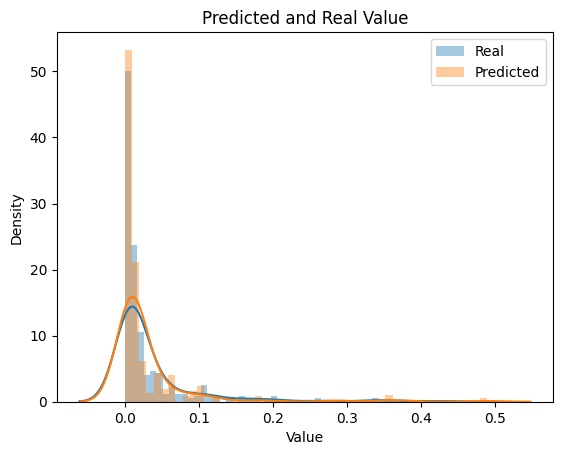

In [31]:
# import plotly.figure_factory as ff

# # Create distplot with curve_type set to 'normal'
# fig = ff.create_distplot(
#     [y_test, df_eval['model_trained'].iloc[0].predict(x_test)], 
#     ['Real', 'Predicted'],
#     # nbins=50,
#     bin_size=150,
#     # show_hist=False
#     # colors=['#636EFA', '#EF553B']
# )
#     # show_hist=False)

# # Add title
# fig.update_layout(title_text='Predicted and Real Value')
# fig.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Create a Seaborn distplot
sns.distplot(y_test, label='Real')
sns.distplot(df_eval['model_trained'].iloc[0].predict(x_test), label='Predicted')

# Add labels and legend
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Predicted and Real Value')
plt.legend()

# Show plot
plt.show()


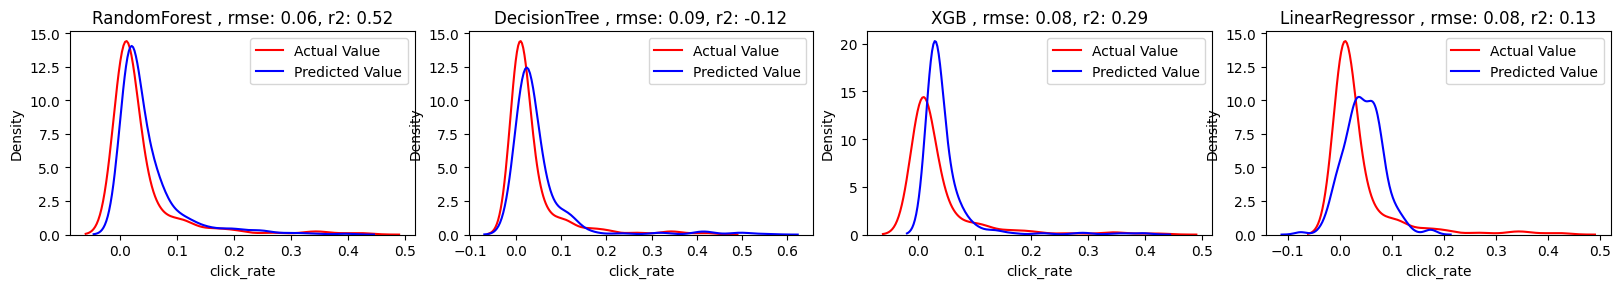

In [49]:

# Let's see the distribution of our predicted values in comparison with the actual values.
j = 1
plt.figure(figsize=(20,10))
for name, custom_feature, custom_target, model_trained, score, r2 in df_eval[['name', 'custom_features', 'custom_target', 'model_trained', 'rmse_cv', 'r2_testset']].values:
    prediction = model_trained.predict(x_test)

    plt.subplot(4, 5, j)
    ax1 = sns.kdeplot(y_test,color ="r",label ="Actual Value")
    sns.kdeplot(prediction ,color ="b",label = "Predicted Value",ax =ax1).set_title(name + ' ' + f', rmse: {round(score, 2)}' + f', r2: {round(r2, 2)}')
    j+=1
    plt.legend()
plt.tight_layout(pad = 0.5)
# Save the image
plt.savefig('predicted_vs_actual_distribution.png')

In [94]:
# We will use plotly for interactivity
import plotly.graph_objects as go
class PlotBoxR(object):
    def __Trace(self,nameOfFeature,value): 
        trace = go.Box(
            y=value,
            name = nameOfFeature,
        )
        return trace

    def PlotResult(self,names,results,combination):
        data = []
        for i in range(len(names)):
            data.append(self.__Trace(names.iloc[i],results.iloc[i]))
        figure = go.Figure(data=data)
        figure.update_layout(title=str(combination))
        return figure

In [95]:
# we have to transform our score column to bring it back to a python list
df_eval['all_scores_cv'] = df_eval['all_scores_cv'].apply(lambda x: [float(i) for i in x.strip('[]').split()])

In [96]:
combinations = ({'custom_feature': True, 'custom_target': True}, {'custom_feature': True, 'custom_target': False}, {'custom_feature': False, 'custom_target': True}, {'custom_feature': False, 'custom_target': False})
for combination in combinations:
    plot_df = df_eval.loc[(df_eval['custom_features'] == combination['custom_feature']) & (df_eval['custom_target'] == combination['custom_target'])]
    PlotBoxR().PlotResult(plot_df['name'],plot_df['all_scores_cv'], combination).show()

In [98]:
x = pd.read_csv("test_data.csv")
x.head(1)

,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,no_of_image,is_personalised,no_of_quotes,no_of_emoticons,is_discount,is_price,is_urgency,target_audience
0,3,61,12871,11,6,1,Noon,6,26,3,37,1,0,0,1,0,0,0,14


In [110]:
model.predict(x)

array([0.05882838, 0.53167283, 0.19386482, 0.19677098, 0.13292932,
       0.03477087, 0.00779402, 0.01636964, 0.0134632 , 0.03176421,
       0.02068363, 0.02246803, 0.01950255, 0.02217637, 0.01487072,
       0.01113291, 0.01087676, 0.01711012, 0.02374946, 0.04304245,
       0.02066396, 0.02059923, 0.00732283, 0.0085494 , 0.01525815,
       0.01506981, 0.07323536, 0.0115937 , 0.08048308, 0.01493894,
       0.01246231, 0.04640728, 0.00693994, 0.15793881, 0.03440591,
       0.05364845, 0.00883283, 0.00464311, 0.00931374, 0.03756371,
       0.0108575 , 0.01568173, 0.00860874, 0.06586686, 0.06693137,
       0.00450616, 0.03792668, 0.01688612, 0.03702339, 0.01238037,
       0.01982515, 0.01340142, 0.01076536, 0.01983687, 0.00775956,
       0.01070507, 0.05433456, 0.01478868, 0.00641959, 0.00425997,
       0.08318773, 0.00589871, 0.02529484, 0.00440889, 0.01642248,
       0.01066576, 0.00523704, 0.06160596, 0.01218854, 0.06476419,
       0.01553685, 0.22313887, 0.01663405, 0.01491764, 0.08844

In [108]:
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_pipeline',
                                                  Pipeline(steps=[('attr_combiner',
                                                                   AttributeCombiner()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['day_of_week', 'subject_len',
                                                   'body_len',
                                                   'mean_paragraph_len',
                                                   'no_of_CTA', 'mean_CTA_len',
                                                   'no_of_image',
                                                   'no_of_quotes',
                                                   'no_of_emoticons']),
                                                 ('categorical_pipeline',
                                                  Pipeline(st...
                                                  ['is_discount', 'is_price',
                                                   'is_urgency',
                                                   'is_personalised',
                                                   'is_weekend', 'sender',
                                                   'category', 'product',
                                                   'target_audience']),
                                                 ('one_hot_pipeline',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['times_of_day'])])),
                ('model',
                 RandomForestRegressor(bootstrap=False, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=400))])

In [107]:
import plotly.express as px
from sklearn.metrics import r2_score

# Now, let's check out the residuals of each model.
# Select the model as you want, here i'm selecting the most accurate model
model = df_eval.sort_values(by='r2_testset')['model_trained'].iloc[5]
# predict the values of the entire data
prediction = model.predict(X)
# calculate the residual
resid = prediction - Y

# create a copy to not alter the original data
df_plot = df.copy()
# create a column to identify the data regarding to train or test
df_plot['split'] = 'train'
df_plot.loc[x_test.index, 'split'] = 'test'
df_plot['prediction'] = prediction
df_plot['resid'] = resid

# plot the residual plot with the histograms
fig = px.scatter(
    df_plot, x='prediction', y='resid',
    marginal_x='histogram', marginal_y='histogram',
    color='split', trendline='ols', opacity=.5
)

# add an annotation with the train R2
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.005,
            y=0.70,
            text=f"Train R²: {round(r2_score(df_plot.loc[df_plot['split'] == 'train']['click_rate'], df_plot.loc[df_plot['split'] == 'train']['prediction']), 3)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="red",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

# add an annotation with the test R2
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.080,
            y=0.70,
            text=f"Test R²: {round(r2_score(df_plot.loc[df_plot['split'] == 'test']['click_rate'], df_plot.loc[df_plot['split'] == 'test']['prediction']), 3)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="blue",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

# add an annotation with the train RMSE
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.005,
            y=0.005,
            text=f"Train RMSE: {round(mean_squared_error(df_plot.loc[df_plot['split'] == 'train']['click_rate'], df_plot.loc[df_plot['split'] == 'train']['prediction'], squared=False), 2)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="red",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

# add an annotation with the test RMSE
fig.add_annotation(
            xref="paper",
            yref="paper",
            x=0.1,
            y=0.005,
            text=f"Test RMSE: {round(mean_squared_error(df_plot.loc[df_plot['split'] == 'test']['click_rate'], df_plot.loc[df_plot['split'] == 'test']['prediction'], squared=False), 2)}",
            bordercolor="#c7c7c7",
            borderwidth=2,
            borderpad=4,
            bgcolor="blue",
            opacity=0.8,
            showarrow=False,
            font=dict(
                family="Courier New, monospace",
                size=12,
                color="#ffffff"
            )
            )

fig.show()

C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

C:\Users\teni\Documents\Damilola Project\Click-Through rate prediction\env\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



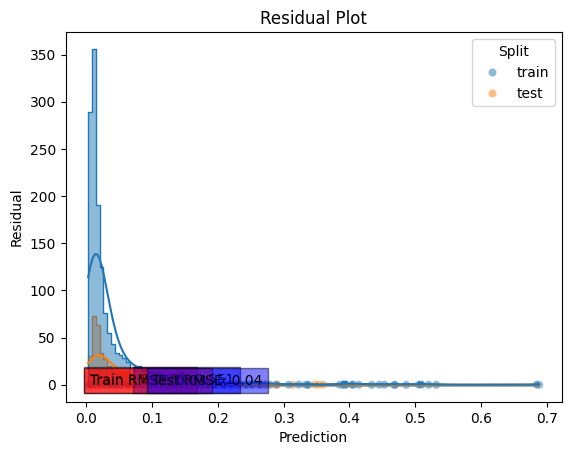

In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error

# Select the model as you want, here I'm selecting the most accurate model
# Predict the values of the entire data
prediction = model.predict(X)
# Calculate the residual
resid = prediction - Y

# Create a copy to not alter the original data
df_plot = df.copy()
# Create a column to identify the data regarding to train or test
df_plot['split'] = 'train'
df_plot.loc[x_test.index, 'split'] = 'test'
df_plot['prediction'] = prediction
df_plot['resid'] = resid

# Plot residuals
sns.scatterplot(data=df_plot, x='prediction', y='resid', hue='split', alpha=0.5)
sns.histplot(data=df_plot, x='prediction', hue='split', kde=True, element='step', fill=True, alpha=0.5)

# Add annotations for train R2, test R2, train RMSE, and test RMSE
plt.text(0.005, 0.70, f"Train R²: {round(r2_score(df_plot.loc[df_plot['split'] == 'train']['click_rate'], df_plot.loc[df_plot['split'] == 'train']['prediction']), 3)}", bbox=dict(facecolor='red', alpha=0.5))
plt.text(0.080, 0.70, f"Test R²: {round(r2_score(df_plot.loc[df_plot['split'] == 'test']['click_rate'], df_plot.loc[df_plot['split'] == 'test']['prediction']), 3)}", bbox=dict(facecolor='blue', alpha=0.5))
plt.text(0.005, 0.005, f"Train RMSE: {round(mean_squared_error(df_plot.loc[df_plot['split'] == 'train']['click_rate'], df_plot.loc[df_plot['split'] == 'train']['prediction'], squared=False), 2)}", bbox=dict(facecolor='red', alpha=0.5))
plt.text(0.1, 0.005, f"Test RMSE: {round(mean_squared_error(df_plot.loc[df_plot['split'] == 'test']['click_rate'], df_plot.loc[df_plot['split'] == 'test']['prediction'], squared=False), 2)}", bbox=dict(facecolor='blue', alpha=0.5))

# Add labels and title
plt.xlabel('Prediction')
plt.ylabel('Residual')
plt.title('Residual Plot')
plt.legend(title='Split')

# Show plot
plt.show()
